In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

sns.set_style('whitegrid')
sns.set_context('notebook')

# Chromosomes

## Bin Coverage of Genomes

Get crude bin identities via `chromosome_coverage/blast_chroms.sh`

BLASTN search of chromosomes as a databases for each set of binned query contigs.

Fortunately, there is only a single chromosome for each genome

In [2]:
chrom_df = pd.read_csv('chromosome_coverage/chroms_blast_all.out6', 
                 sep='\t', 
                 names = "qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen qcovs binner assembly bin".split())
chrom_df['species'] = chrom_df['sseqid'].str.split(':').str.get(0)

bin_sizes = pd.read_csv('bin_sizes.csv').set_index('bin')
genome_sizes = pd.read_csv('genome_sizes.csv').set_index('genome')

# drop the unbinned
chrom_df = chrom_df[~chrom_df['bin'].str.startswith('unbinned')]

In [3]:
# assess how much of each reference genome is found inside each bin
# first we need to collapse the overlapping blast hits in the genome

chrom_df_sub = chrom_df.loc[:, ['bin', 'binner', 'assembly', 'species', 'sstart', 'send']]
chrom_df_sub.loc[:, 'lower_ix'] = chrom_df_sub[['sstart','send']].min(axis=1)
chrom_df_sub.loc[:, 'higher_ix'] = chrom_df_sub[['sstart','send']].max(axis=1)
chrom_df_sub = chrom_df_sub.drop(['sstart', 'send'], axis=1)

chrom_df_sub = chrom_df_sub.groupby(['binner', 'assembly', 'species', 'bin']).apply(lambda x: x.sort_values(["lower_ix"]))

from collections import defaultdict
ranges = defaultdict(list)
for ix, row in chrom_df_sub.iterrows():
    ix = ix[:-1]
    ranges[ix].append((row['lower_ix'], row['higher_ix']))

def merge_intervals(intervals):
    sorted_by_lower_bound = sorted(intervals, key=lambda tup: tup[0])
    merged = []
    for higher in sorted_by_lower_bound:
        if not merged:
            merged.append(higher)
        else:
            lower = merged[-1]
            # test for intersection between lower and higher:
            # we know via sorting that lower[0] <= higher[0]
            if higher[0] <= lower[1]:
                upper_bound = max(lower[1], higher[1])
                merged[-1] = (lower[0], upper_bound)  # replace by merged interval
            else:
                merged.append(higher)
    return merged

for ix, hit_regions in ranges.items():
    ranges[ix] = merge_intervals(hit_regions)
    
    
# then we need to rebuild a dataframe
collapsed_hits = {'binner':[], 'assembly':[], 'species':[], 'bin': [], 'lower_ix': [], 'higher_ix': []}

for ix, hit_regions in ranges.items():
    for range_ixs in hit_regions:
        collapsed_hits['binner'].append(ix[0])
        collapsed_hits['assembly'].append(ix[1])
        collapsed_hits['species'].append(ix[2])
        collapsed_hits['bin'].append(ix[3])
        collapsed_hits['lower_ix'].append(range_ixs[0])
        collapsed_hits['higher_ix'].append(range_ixs[1])
        
# and sum the total source chromosome covered
collapsed_hits = pd.DataFrame(collapsed_hits)
collapsed_hits['length'] = collapsed_hits['higher_ix'] - collapsed_hits['lower_ix']
collapsed_hits = collapsed_hits.groupby(['binner', 'assembly', 'species', 'bin'])['length'].sum().reset_index()
collapsed_hits = collapsed_hits.set_index('species')
collapsed_hits['genome_size'] = genome_sizes
collapsed_hits['coverage'] = collapsed_hits['length'] / collapsed_hits['genome_size'] *100
collapsed_hits = collapsed_hits.reset_index()

In [29]:
collapsed_hits_grp = collapsed_hits.groupby(['binner', 'assembly', 'bin'])
max_ix = collapsed_hits_grp['coverage'].idxmax().values
top_hits_per_bin = collapsed_hits.loc[max_ix]

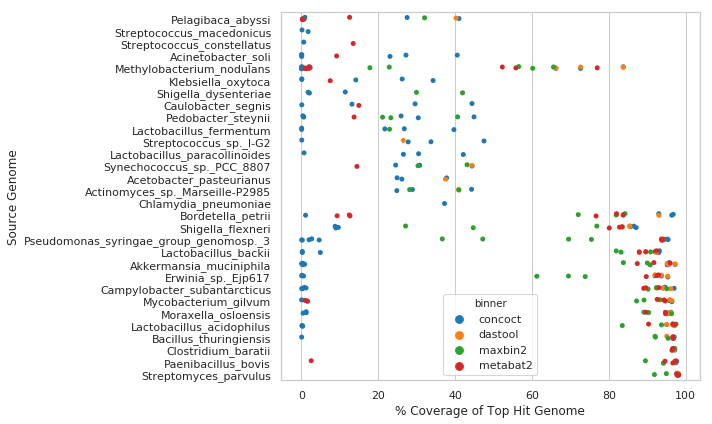

In [47]:
order = top_hits_per_bin.groupby('species')['coverage'].median().sort_values().index
fig, ax = plt.subplots(figsize=(10,6))
sns.stripplot(ax = ax, data = top_hits_per_bin, y='species', x='coverage', order=order, hue='binner')
plt.xlabel('% Coverage of Top Hit Genome')
plt.ylabel('Source Genome')
plt.tight_layout()
plt.savefig('s1_species_top_coverage.png', dpi=300)

In [58]:
top_hits_per_bin.groupby('species')['coverage'].min()

species
Acetobacter_pasteurianus                  24.891028
Acinetobacter_soli                         0.043385
Actinomyces_sp._Marseille-P2985           24.815325
Akkermansia_muciniphila                    0.046259
Bacillus_thuringiensis                     0.064113
Bordetella_petrii                          1.076183
Campylobacter_subantarcticus               0.075442
Caulobacter_segnis                         0.098451
Chlamydia_pneumoniae                      37.020035
Clostridium_baratii                       96.409578
Erwinia_sp._Ejp617                         0.079747
Klebsiella_oxytoca                         0.093861
Lactobacillus_acidophilus                  0.139117
Lactobacillus_backii                       0.222623
Lactobacillus_fermentum                    0.049608
Lactobacillus_paracollinoides              0.677760
Methylobacterium_nodulans                  0.021310
Moraxella_osloensis                        0.429889
Mycobacterium_gilvum                       0.043545
Paen

In [59]:
top_hits_per_bin.groupby('species')['coverage'].max()

species
Acetobacter_pasteurianus                  37.763115
Acinetobacter_soli                        40.534619
Actinomyces_sp._Marseille-P2985           44.257309
Akkermansia_muciniphila                   97.233920
Bacillus_thuringiensis                    96.999440
Bordetella_petrii                         96.733455
Campylobacter_subantarcticus              96.971078
Caulobacter_segnis                        44.375095
Chlamydia_pneumoniae                      37.020035
Clostridium_baratii                       97.140557
Erwinia_sp._Ejp617                        95.311267
Klebsiella_oxytoca                        34.253914
Lactobacillus_acidophilus                 97.471319
Lactobacillus_backii                      93.130119
Lactobacillus_fermentum                   39.668779
Lactobacillus_paracollinoides             42.118271
Methylobacterium_nodulans                 83.735824
Moraxella_osloensis                       96.288923
Mycobacterium_gilvum                      96.396246
Paen

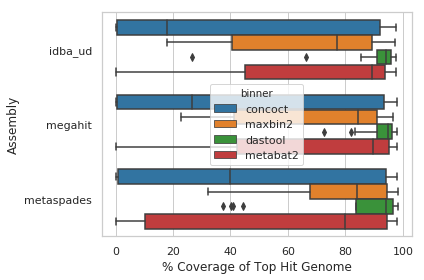

In [5]:
sns.boxplot(data = top_hits_per_bin, hue_order = ['concoct', 'maxbin2', 'dastool', 'metabat2'], y='assembly', hue='binner', x='coverage')
plt.xlabel('% Coverage of Top Hit Genome')
plt.ylabel('Assembly')
plt.tight_layout()
plt.savefig('1a_top_coverage.pdf')
plt.savefig('1a_top_coverage.png')
plt.savefig('1a_top_coverage.svg')

In [61]:
top_hits_per_bin.groupby('assembly')['coverage'].median()

assembly
idba_ud       78.370454
megahit       81.977945
metaspades    76.847851
Name: coverage, dtype: float64

In [62]:
top_hits_per_bin.groupby('binner')['coverage'].median()

binner
concoct     26.030626
dastool     94.267832
maxbin2     83.150909
metabat2    88.480494
Name: coverage, dtype: float64

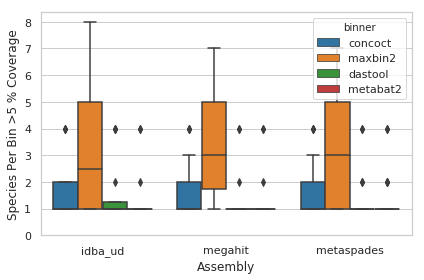

In [25]:
sub = collapsed_hits[collapsed_hits['coverage'] > 5]
sub = sub.groupby(['binner', 'assembly', 'bin'])['species'].size().reset_index()
sns.boxplot(data = sub, hue_order = ['concoct', 'maxbin2', 'dastool', 'metabat2'], x='assembly', hue='binner', y='species')
plt.ylim(0,)
plt.xlabel('Assembly')
plt.ylabel('Species Per Bin >5 % Coverage')
plt.tight_layout()
plt.savefig('1b_purity.pdf')
plt.savefig('1b_purity.svg')
plt.savefig('1b_purity.png')

In [69]:
sub.groupby('assembly')['species'].describe()

,count,mean,std,min,25%,50%,75%,max
assembly,,,,,,,,
idba_ud,78.0,1.948718,1.578240,1.0,1.0,1.0,2.0,8.0
megahit,78.0,1.948718,1.510977,1.0,1.0,1.0,2.0,7.0
metaspades,89.0,1.853933,1.473636,1.0,1.0,1.0,2.0,7.0


In [70]:
sub.groupby('binner')['species'].describe()

,count,mean,std,min,25%,50%,75%,max
binner,,,,,,,,
concoct,82.0,1.548780,0.983223,1.0,1.0,1.0,2.0,4.0
dastool,50.0,1.500000,1.054630,1.0,1.0,1.0,1.0,4.0
maxbin2,59.0,3.220339,2.051642,1.0,1.0,3.0,5.0,8.0
metabat2,54.0,1.425926,0.963521,1.0,1.0,1.0,1.0,4.0


In [74]:
sub[sub['species'] > 1].groupby('binner').size()

binner
concoct     25
dastool     11
maxbin2     41
metabat2    11
dtype: int64

In [7]:
# amount of genomes not in any bin (just dump bin requirement)
chrom_df_sub = chrom_df.loc[:, ['binner', 'assembly', 'species', 'sstart', 'send']]
chrom_df_sub.loc[:, 'lower_ix'] = chrom_df_sub[['sstart','send']].min(axis=1)
chrom_df_sub.loc[:, 'higher_ix'] = chrom_df_sub[['sstart','send']].max(axis=1)
chrom_df_sub = chrom_df_sub.drop(['sstart', 'send'], axis=1)

chrom_df_sub = chrom_df_sub.groupby(['binner', 'assembly', 'species']).apply(lambda x: x.sort_values(["lower_ix"]))

from collections import defaultdict
ranges = defaultdict(list)
for ix, row in chrom_df_sub.iterrows():
    ix = ix[:-1]
    ranges[ix].append((row['lower_ix'], row['higher_ix']))

for ix, hit_regions in ranges.items():
    ranges[ix] = merge_intervals(hit_regions)
    
    
# then we need to rebuild a dataframe
missing_hits = {'binner':[], 'assembly':[], 'species':[], 'lower_ix': [], 'higher_ix': []}

for ix, hit_regions in ranges.items():
    for range_ixs in hit_regions:
        missing_hits['binner'].append(ix[0])
        missing_hits['assembly'].append(ix[1])
        missing_hits['species'].append(ix[2])
        missing_hits['lower_ix'].append(range_ixs[0])
        missing_hits['higher_ix'].append(range_ixs[1])
        
# and sum the total source chromosome covered
missing_hits = pd.DataFrame(missing_hits)
missing_hits['length'] = missing_hits['higher_ix'] - missing_hits['lower_ix']
missing_hits = missing_hits.groupby(['binner', 'assembly', 'species'])['length'].sum().reset_index()
missing_hits = missing_hits.set_index('species')
missing_hits['genome_size'] = genome_sizes
missing_hits['unbinned%'] = 100 - (missing_hits['length'] / missing_hits['genome_size'] * 100)

/bioinf/anaconda3/envs/eda/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


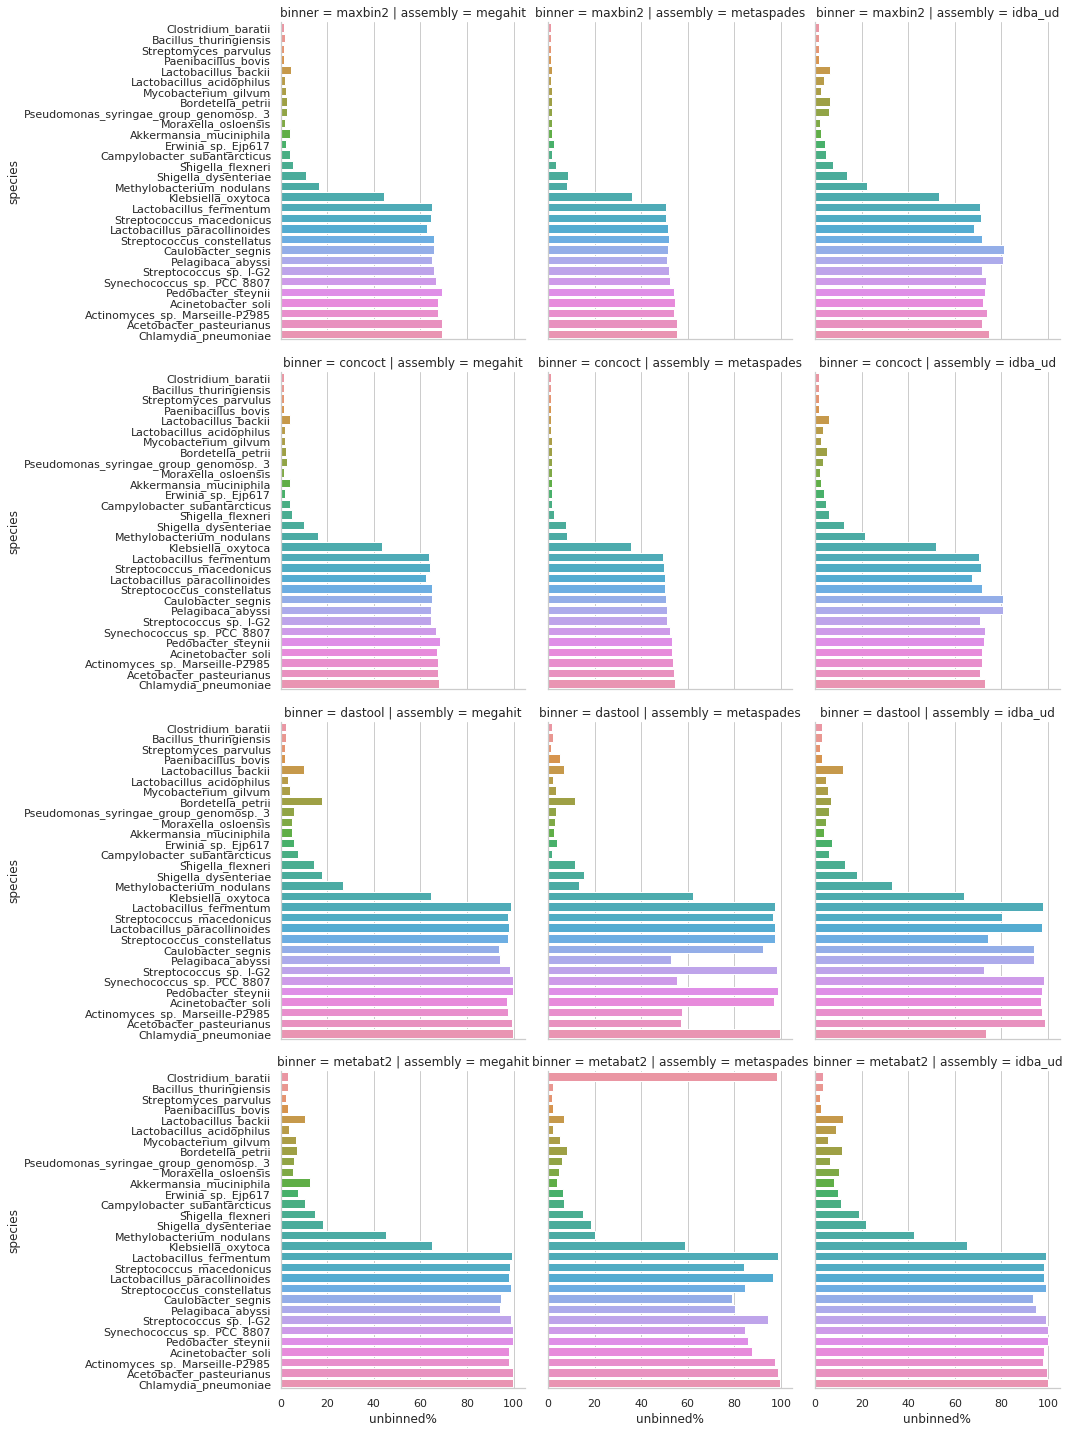

In [8]:
sns.factorplot(data = missing_hits.reset_index().sort_values('unbinned%'),
                y='species', x='unbinned%', col='assembly', row='binner', kind='bar')

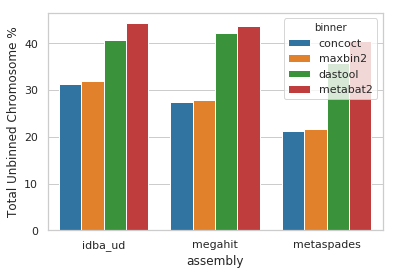

In [9]:
unbinned_overall = 100 - (missing_hits.groupby(['binner', 'assembly'])['length'].sum() / missing_hits.groupby(['binner', 'assembly'])['genome_size'].sum() * 100)
unbinned_overall = unbinned_overall.reset_index().rename(columns={0:'Total Unbinned Chromosome %'})
sns.barplot(data = unbinned_overall, hue_order = ['concoct', 'maxbin2', 'dastool', 'metabat2'], y='Total Unbinned Chromosome %', x='assembly', hue='binner')

In [10]:
unbinned_overall['Total Unbinned Chromosome %'].describe()

count    12.000000
mean     34.061704
std       8.346184
min      21.268367
25%      27.755970
50%      33.809317
75%      41.096049
max      44.270272
Name: Total Unbinned Chromosome %, dtype: float64

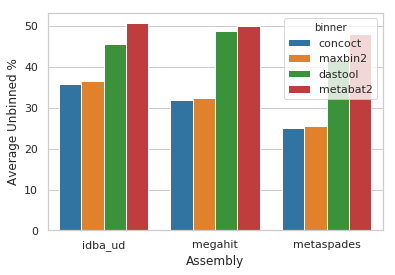

In [11]:
unbinned_av = missing_hits.groupby(['binner', 'assembly'])['unbinned%'].sum() / 30 
unbinned_av = unbinned_av.reset_index()
sns.barplot(data = unbinned_av, hue_order = ['concoct', 'maxbin2', 'dastool', 'metabat2'], y='unbinned%', x='assembly', hue='binner')
plt.ylabel('Average Unbinned %')
plt.xlabel('Assembly')
plt.savefig('1c_unbinned_perc.pdf')
plt.savefig('1c_unbinned_perc.svg')
plt.savefig('1c_unbinned_perc.png')

Text(0, 0.5, 'Average Unbinned %')

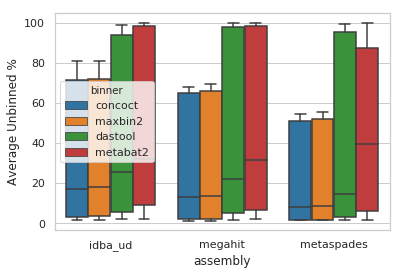

In [12]:
sns.boxplot(data = missing_hits, hue_order = ['concoct', 'maxbin2', 'dastool', 'metabat2'], y='unbinned%', x='assembly', hue='binner')
plt.ylabel('Average Unbinned %')

In [26]:
missing_hits

,binner,assembly,length,genome_size,unbinned%
species,,,,,
Acetobacter_pasteurianus,concoct,idba_ud,925193,3172135,70.833744
Acinetobacter_soli,concoct,idba_ud,992472,3487419,71.541361
Actinomyces_sp._Marseille-P2985,concoct,idba_ud,540810,1919588,71.826767
Akkermansia_muciniphila,concoct,idba_ud,2631040,2702163,2.632077
Bacillus_thuringiensis,concoct,idba_ud,5220206,5312509,1.737465
Bordetella_petrii,concoct,idba_ud,5095701,5363495,4.992901
Campylobacter_subantarcticus,concoct,idba_ud,1722918,1808003,4.706021
Caulobacter_segnis,concoct,idba_ud,905067,4722133,80.833513
Chlamydia_pneumoniae,concoct,idba_ud,336487,1243451,72.939263


very crude single genome IDs for each bin based on which genome 
that bin contains the largest proportion of a given genome 

In [13]:
collapsed_hits_grp = collapsed_hits.groupby(['binner', 'assembly', 'bin'])
max_ix = collapsed_hits_grp['coverage'].idxmax().values
top_hits_per_bin = collapsed_hits.loc[max_ix]
top_hits_per_bin = top_hits_per_bin.drop(['length', 'genome_size', 'coverage'], axis=1)
top_hits_per_bin['bin'] = top_hits_per_bin['bin'].str.replace('_chroms.out6', '')
top_hits_per_bin = top_hits_per_bin.set_index(['assembly', 'binner', 'bin'])

# Plasmids

How many plasmids were recovered and were they in the same bin as their respective chromosomes

In [14]:
plas_df = pd.read_csv('plasmid_coverage/plasmids_blast_all.out6', 
                 sep='\t', 
                names = "qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen qcovs binner assembly bin".split())

plas_df['coverage'] = plas_df['length'] / plas_df['qlen'] * 100
plas_df = plas_df[plas_df['coverage'] > 50]


plas_df['plas_genome'] = plas_df['qseqid'].str.split(':').str.get(0)
plas_df['plas_acc'] = plas_df['qseqid'].str.split(':').str.get(1)
plas_df['bin'] = plas_df['bin'].str.replace('_plasmids.out6', '')


unbinned_plas = plas_df[plas_df['bin'].str.startswith('unbinned')]
binned_plas = plas_df[~plas_df['bin'].str.startswith('unbinned')]


binned_plas = binned_plas.set_index(['assembly', 'binner', 'bin'])
binned_plas['bin_id'] = top_hits_per_bin['species']
binned_plas = binned_plas.reset_index()


plas_counts = !ls -1 ../data/sequences/*/*/plasmid/*.fasta
plas_counts = [x.split('/')[3] for x in plas_counts]
plas_counts = pd.Series(collections.Counter(plas_counts))

In [15]:
assembled = plas_df.groupby(['assembly', 'binner'])['plas_acc'].nunique()
assembled.name = 'Assembled'
binned = binned_plas.groupby(['assembly', 'binner'])['plas_acc'].nunique()
binned.name = 'Binned'
correct = binned_plas[binned_plas['plas_genome'] == binned_plas['bin_id']].groupby(['assembly', 'binner'])['plas_acc'].nunique()
correct.name = 'Correctly Binned'

In [16]:
plasmid_scores = pd.concat([assembled, binned, correct], axis=1) / 65 * 100
plasmid_scores = plasmid_scores.reset_index()
plasmid_scores = pd.melt(plasmid_scores, id_vars=['assembly', 'binner'], var_name='Category', value_name='% of Plasmids (>50% coverage)')

/bioinf/anaconda3/envs/eda/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


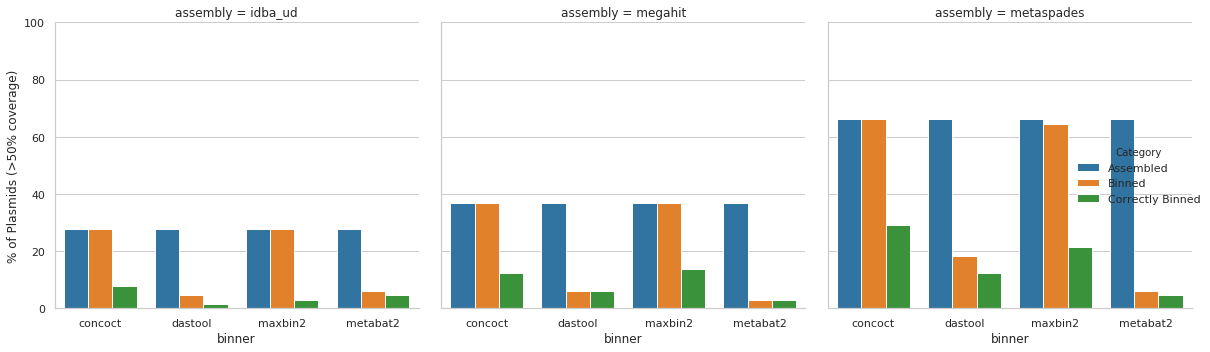

In [17]:
sns.factorplot(data = plasmid_scores, hue='Category', col='assembly', x = 'binner', y='% of Plasmids (>50% coverage)', kind='bar')
plt.ylim(0,100)
plt.tight_layout()
plt.savefig('2_plasmid_coverage.svg')
plt.savefig('2_plasmid_coverage.pdf')
plt.savefig('2_plasmid_coverage.png', dpi=300)

In [77]:
plasmid_scores[plasmid_scores['Category'] == 'Correctly Binned']['% of Plasmids (>50% coverage)'].describe()

count    12.000000
mean     10.000000
std       8.388111
min       1.538462
25%       4.230769
50%       6.923077
75%      12.692308
max      29.230769
Name: % of Plasmids (>50% coverage), dtype: float64

In [81]:
plasmid_scores[plasmid_scores['Category'] == 'Assembled']['% of Plasmids (>50% coverage)']

0     27.692308
1     27.692308
2     27.692308
3     27.692308
4     36.923077
5     36.923077
6     36.923077
7     36.923077
8     66.153846
9     66.153846
10    66.153846
11    66.153846
Name: % of Plasmids (>50% coverage), dtype: float64

In [102]:
plasmid_scores.sort_values('% of Plasmids (>50% coverage)')

,assembly,binner,Category,% of Plasmids (>50% coverage)
25,idba_ud,dastool,Correctly Binned,1.538462
31,megahit,metabat2,Correctly Binned,3.076923
26,idba_ud,maxbin2,Correctly Binned,3.076923
19,megahit,metabat2,Binned,3.076923
35,metaspades,metabat2,Correctly Binned,4.615385
27,idba_ud,metabat2,Correctly Binned,4.615385
13,idba_ud,dastool,Binned,4.615385
29,megahit,dastool,Correctly Binned,6.153846
23,metaspades,metabat2,Binned,6.153846
15,idba_ud,metabat2,Binned,6.153846


# Genomic Islands

In [19]:
gi_df = pd.read_csv('gi_coverage/gis_blast_all.out6',
                 sep='\t', 
                names = "qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen qcovs binner assembly bin".split())

gi_df['gi_genome'] = gi_df['qseqid'].str.split(':').str.get(0)
gi_df['bin'] = gi_df['bin'].str.replace('_gis.out6', '')

gi_df = gi_df.set_index(['assembly', 'binner', 'bin'])
gi_df['bin_id'] = top_hits_per_bin['species']
gi_df = gi_df.reset_index()
gi_df['coverage'] = gi_df['length'] / gi_df['qlen'] * 100

# drop coverage <50%
gi_df = gi_df[gi_df['coverage'] > 50]


unbinned_gis = gi_df[gi_df['bin'].str.startswith('unbinned')]
binned_gis = gi_df[~gi_df['bin'].str.startswith('unbinned')]


binned_gis = binned_gis.set_index(['assembly', 'binner', 'bin'])
binned_gis['bin_id'] = top_hits_per_bin['species']
binned_gis = binned_gis.reset_index().set_index(['assembly', 'binner'])

gi_counts = !grep -c "^>" ../data/sequences/*/gis/*.fasta
gi_counts = {x.split('/')[3]: int(x.split(':')[-1]) for x in gi_counts}
gi_counts = pd.Series(gi_counts)

In [20]:
assembled = gi_df.groupby(['assembly', 'binner'])['qseqid'].nunique()
assembled.name = 'Assembled'
binned = binned_gis.groupby(['assembly', 'binner'])['qseqid'].nunique()
binned.name = 'Binned'
correct = binned_gis[binned_gis['gi_genome'] == binned_gis['bin_id']].groupby(['assembly', 'binner'])['qseqid'].nunique()
correct.name = 'Correctly Binned'

In [21]:
gi_scores = pd.concat([assembled, binned, correct], axis=1) / gi_counts.sum() * 100
gi_scores = gi_scores.reset_index()
gi_scores = pd.melt(gi_scores, id_vars=['assembly', 'binner'], var_name='Category', value_name='% of GIs (>50% Coverage)')

/bioinf/anaconda3/envs/eda/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


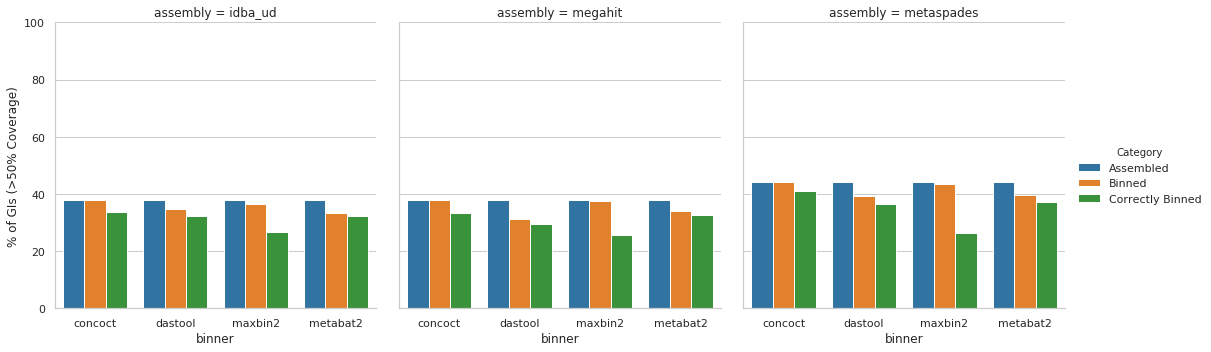

In [22]:
sns.factorplot(data = gi_scores, hue='Category', col='assembly', x = 'binner', y='% of GIs (>50% Coverage)', kind='bar')
plt.ylim(0, 100)
plt.savefig('3_gi_coverage.svg')
plt.savefig('3_gi_coverage.pdf')
plt.savefig('3_gi_coverage.png', dpi=300)


In [115]:
gi_scores.query("Category == 'Binned'").sort_values('% of GIs (>50% Coverage)')

,assembly,binner,Category,% of GIs (>50% Coverage)
17,megahit,dastool,Binned,31.074380
15,idba_ud,metabat2,Binned,33.223140
19,megahit,metabat2,Binned,33.884298
13,idba_ud,dastool,Binned,34.710744
14,idba_ud,maxbin2,Binned,36.363636
18,megahit,maxbin2,Binned,37.685950
12,idba_ud,concoct,Binned,37.851240
16,megahit,concoct,Binned,37.851240
21,metaspades,dastool,Binned,39.173554
23,metaspades,metabat2,Binned,39.504132


In [116]:
gi_scores.query("Category == 'Correctly Binned'").sort_values('% of GIs (>50% Coverage)')

,assembly,binner,Category,% of GIs (>50% Coverage)
30,megahit,maxbin2,Correctly Binned,25.619835
34,metaspades,maxbin2,Correctly Binned,26.446281
26,idba_ud,maxbin2,Correctly Binned,26.611570
29,megahit,dastool,Correctly Binned,29.421488
27,idba_ud,metabat2,Correctly Binned,32.231405
25,idba_ud,dastool,Correctly Binned,32.396694
31,megahit,metabat2,Correctly Binned,32.561983
28,megahit,concoct,Correctly Binned,33.388430
24,idba_ud,concoct,Correctly Binned,33.553719
33,metaspades,dastool,Correctly Binned,36.363636


In [107]:
gi_scores.sort_values('% of GIs (>50% Coverage)')

,assembly,binner,Category,% of GIs (>50% Coverage)
30,megahit,maxbin2,Correctly Binned,25.619835
34,metaspades,maxbin2,Correctly Binned,26.446281
26,idba_ud,maxbin2,Correctly Binned,26.611570
29,megahit,dastool,Correctly Binned,29.421488
17,megahit,dastool,Binned,31.074380
27,idba_ud,metabat2,Correctly Binned,32.231405
25,idba_ud,dastool,Correctly Binned,32.396694
31,megahit,metabat2,Correctly Binned,32.561983
15,idba_ud,metabat2,Binned,33.223140
28,megahit,concoct,Correctly Binned,33.388430


In [24]:
pwd

'/home/fin/documents/postdoc/MAG_gi_plasmid_analysis/mag_assessment'